<center> <h1> Computer Assignment 5 </h1> </center>
<center> <h1> Group 3 </h1> </center>

# Introduction

In this assignment we implemented the multiclass SVM and ADMM and evaluated the test accuracy for MNIST dataset.

In [1]:
##imports from libraries
import pandas as pd
import numpy as np
import time
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import resource
import time
from datetime import datetime
import math
import os
from sklearn import preprocessing
import sys
#import cvxpy
from multiprocessing import Process, Pipe
from multiprocessing.pool import ThreadPool
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from random import randint

Using TensorFlow backend.


In [2]:
# Preparing the dataset
#Divide the training data set into 10 data sets
N = 60000
M = 10000
num_workers = 10 #Number of workers
num_classes = 10 #Number of output classes
image_size = 784
numSamples = N//num_workers #Number of training samples per worker

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size).T
x_test = x_test.reshape(x_test.shape[0], image_size).T

X = {}
Y = {}

for idx in range(num_workers):
    X[idx] = x_train[:,idx*numSamples:(idx+1)*numSamples]
    Y[idx] = y_train[idx*numSamples:(idx+1)*numSamples]

# Data processing
x_train is of size 784x60000 contaning 60000 examples each with 784 features. y_train is of size 60000x1 and each y value is the number in the corresponding example image. We have divided the data set into 10 data sets. X is a list containing 10 ndarrays of size 784x6000 and Y is a list containing 10 ndarrays of size 6000x1.

# One-versus-rest (soft-margin) SVM
We first describe the binary-class SVM and describe how it is applied for the case of multi class. The binary-class SVM classifies an input example $i$ into a postive example or a negative example indicated, respectively, by $t_i = 1$ and $t_i = -1$ in the training set. The weigth vector $\mathbf{w}$ is trained by minimizing the following function.
$$ f(\mathbf{w}) = \frac{1}{N} \sum_{i\in [N]} \max(0, 1 - t_i \mathbf{w}^T x_i) + \frac{\lambda}{2} ||\mathbf{w}||_2^2, $$
The subgradient of the above function is given by:
$$ \frac{\partial f(\mathbf{w})}{\partial \mathbf{w}} = \frac{1}{N} \sum_{i\in[N]} -t_i x_i \mathbb{1}(t_i \mathbf{w}^T x_i < 1) + \lambda \mathbf{w} $$,
where $\mathbb{1}(\cdot)$ is an indicator function.

For each class $j$, one-versus-rest SVM calls the binary-class SVM by treating all examples of class $j$ are assigned $t_i = 1$ and the rest of the examples are assigned $t_i = -1$. Therefore, for each class $j$, a weight vector $\mathbf{w}_j$ is tranined. For MNIST data set we have 10 classes and thus we train 10 $\mathbf{w}_j$ vectors, which forms the columns of the weight matrix $w_k$ of size $784$x$10$. 

For the test data classification is done as follows. Given test example $\mathbf{x}_i$, we multiply with weight matrix $\mathbf{w}_k$, which results in a vector of size $10$ (a row of the 'socres' variable below). Note that the value of element $j$ of this vector indicates whether the example belongs to class $j$ (if the value is positive) or the not (if the value is negative). We out put $j$, where the value in the vector is the highest. 

# Test accuracy
Using the one-versus-rest SVM we obtained $86\%$ accuracy for the test data set for 100 iterations of the GD algorithm for the case of **star topology**.


In [3]:
#binary SVM classification one-vs-rest loss and its gradient
def bin_SVM_classify(x, w):
    scores = np.matmul(x.T, w)
    #class_votes = np.zeros(scores.shape)
    #class_votes[scores > 0] += 1
    #for i in range(10):
    #    class_votes[scores[:,i] <= 0,:] += 1
    #class_votes[scores <= 0] -= 1
    #return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)
    #return np.argmax(class_votes, axis = 1)
    return np.argmax(scores, axis = 1)

def bin_SVM_classification_err(x,y,w):
    y_estimate = bin_SVM_classify(x, w)
    return sum(y_estimate != y)*100.0/len(y)
            
def bin_SVM_cost(x, y, w):
    svm_cost = - np.matmul(x.T, w) 
    svm_cost[(range(y.shape[0]), y.reshape(y.shape[0]))] *= -1
    return (1 - svm_cost).clip(min = 0)

def bin_regulated_total_cost(x, y, w, lambda_):
    return SVM_cost(x, y, w).sum(axis = 1) + lambda_/2 * np.linalg.norm(w, axis = 1)**2

def bin_SVM_cost_grad(x, y, w, lambda_):
    svm_cost = bin_SVM_cost(x, y, w)
    svm_cost[svm_cost > 0] = 1
    svm_cost_grad = np.zeros((x.shape[0], 10))
    for i in range(10):
        svm_cost_yi = svm_cost[:, i]
        svm_cost_yi[y == i] *= -1
        svm_cost_grad[:, i] = np.multiply(x, svm_cost_yi).sum(axis = 1) + lambda_ * w[:, i]
    return svm_cost_grad

In [ ]:
#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data.
#x dimension is 6000x684
#y dimension is 6000. 
#w dimension is 784x10. Each column of w is trained for one calss vs the rest
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
  
    ## compute the gradients ----------------------------------------
    return bin_SVM_cost_grad(x, y, w_k, lambda_) #train the weights for class i
        

#Distributed Gradient Descent
def decentralized_gradient_descent(x,y,lambda_,learn_rate,max_iter):
    #each class has a w_k
    w_k = np.random.rand(image_size, 10)
    #w_k = w
    T = 0
    itr = 0
    err_test = []
    err_train = []
    #L1 = regulated_total_cost(x_train, y, w_k, lambda_)
    while 1:
        workers_w_k = np.array(10 * [w_k]).reshape(10, image_size, 10)
        grad_w = np.zeros([image_size,num_classes])
        for idx in range(num_workers):
            gf = decentralized_gradient_descent_worker(X[idx],Y[idx],workers_w_k[idx,:,:],lambda_)

            grad_w = grad_w + gf
                    
        #print('grad_w',grad_w.shape)
        grad_w = grad_w/N
        
        #print('w_k',w_k.shape)
        w_k = w_k - learn_rate*grad_w
        
        err_test.append(bin_SVM_classification_err(x_test,y_test,w_k))
        err_train.append(bin_SVM_classification_err(x_train,y_train,w_k))
        
        #print('norm:',np.linalg.norm(w_k,axis=0))
        print(itr)
        itr = itr + 1
        if itr >= max_iter:
            break        
        
    #print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return w_k.reshape(image_size,10), err_test, err_train

#Intialize the parameters
max_iter = 100
lambda_ = 1
learn_rate = 0.005

start = time.time() 
w, err_test, err_train = decentralized_gradient_descent(x_train,y_train,lambda_,learn_rate,max_iter)  
end = time.time()
print('time=',end-start,' seconds')
np.savetxt('w100_star.csv',w,delimiter=',')
np.savetxt('err_test_100_star.csv',err_test,delimiter=',')
np.savetxt('err_train_100_star.csv',err_train,delimiter=',')
err_test
err_train

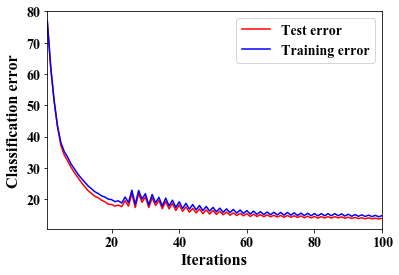

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100
err_test = pd.read_csv("err_test_100_star.csv", delimiter=",", header=None).values
err_train = pd.read_csv("err_train_100_star.csv", delimiter=",", header=None).values

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)
plt.plot(list(range(1,Iterations+1)),err_test,'-r',label = 'Test error')
plt.plot(list(range(1,Iterations+1)),err_train,'-b',label ='Training error')

legend()

# Two-star Communication Graph
For this network, we use the following (double stochastic) transition matrix.  

  
$$A = 
\begin{pmatrix}
5/6 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 5/6 & 0 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 5/6 & 0 & 1/6 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 5/6 & 1/6 & 0 & 0 & 0 & 0 & 0\\
1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6 & 1/6\\
0 & 0 & 0 & 0 & 0 & 1/6 & 5/6 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 5/6 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 5/6 & 0\\
0 & 0 & 0 & 0 & 0 & 1/6 & 0 & 0 & 0 & 5/6
\end{pmatrix}$$

*Number of signalling exchanges* per iteration of decentralized sub-gradient algorithm is equal to 
$$2\sum_i \text{deg}(\text{Node } i) = \text{Number of non-zero non-diagonal elements of }A,$$
which equals 18 for two-start communication graph.

# Test Accuracy
Using the one-versus-rest SVM we computed accuracy for the test data set after 100 iterations. At nodes $1$ and $5$ the test accuracy we obtained is $84\%$ and $88\%$, respectively.

In [6]:
A = np.identity(10)*(5/6)
A[4,0:6]  = 1/6
A[5,5:10] = 1/6
A[0:6,4]  = 1/6
A[5:10,5] = 1/6

In [ ]:
#Each worker computes 10 svm loss gradients based w.r.t w for 10 classes for its partition of data.
#x dimension is 6000x684
#y dimension is 6000. 
#w dimension is 784x10. Each column of w is trained for one calss vs the rest
def decentralized_gradient_descent_worker(x, y, w_k, lambda_):
    
    ## compute the gradients ----------------------------------------
    return bin_SVM_cost_grad(x, y, w_k, lambda_) #train the weights for class i


#Distributed Gradient Descent
def decentralized_gradient_descent(x,y,lambda_,learn_rate,max_iter):
    #each class has a w_k
    workers_w_k_new = np.random.rand(10,image_size, 10)
    workers_w_k_prev = np.random.rand(10,image_size, 10)
    #w_k = w
    T = 0
    itr = 0
    err_test_node1 = []
    err_test_node5 = []
    errLocal_train_node1 = []
    errLocal_train_node5 = []    

    while 1:
        grad_w = np.zeros([image_size,num_classes])
        for idx in range(num_workers):
            #Worker idx first performs consensus step using communication matrix A and then updates its gradient
            #Step 1: Consensus 
            workers_w_k_new[idx,:,:] = np.average(workers_w_k_prev,axis=0,weights=A[idx,:])
            
            #Step 2: Update gradient
            gf = decentralized_gradient_descent_worker(X[idx],Y[idx],workers_w_k_new[idx,:,:],lambda_)

            workers_w_k_new[idx,:,:] = workers_w_k_new[idx,:,:] - learn_rate*gf/numSamples
        
        #Compute classification error using test data for Node 1 and Node 5
        err_test_node1.append(bin_SVM_classification_err(x_test,y_test,workers_w_k_new[0,:,:]))
        
        err_test_node5.append(bin_SVM_classification_err(x_test,y_test,workers_w_k_new[4,:,:]))
        
        #Compute classification error using training data at Node 1 and Node 5
        errLocal_train_node1.append(bin_SVM_classification_err(X[0],Y[0],workers_w_k_new[0,:,:]))
        
        errLocal_train_node5.append(bin_SVM_classification_err(X[4],Y[4],workers_w_k_new[4,:,:]))        

        #Emulating exchange of weights between neighbours. 
        #Number of signalling exchanges this requires is equal to 2*(\sum_i deg(Node i)) = 18 for two-start communication graph
        workers_w_k_prev = workers_w_k_new
        
        #print('norm:',np.linalg.norm(w_k,axis=0))
        print(itr)
        itr = itr + 1
        if itr >= max_iter:
            break        
        
    #print("Final loss = %.3f and gradient norm = %.3f" %(L1, np.linalg.norm(grad_w)))
    return workers_w_k_new, err_test_node1, err_test_node5, errLocal_train_node1, errLocal_train_node5

#Intialize the parameters
max_iter = 100
lambda_ = 1
learn_rate = 0.005

start = time.time() 
w, err_test_node1, err_test_node5, errLocal_train_node1, errLocal_train_node5 = decentralized_gradient_descent(x_train,y_train,lambda_,learn_rate,max_iter)  
end = time.time()
print('time=',end-start,' seconds')
np.savetxt('w100_twoStar_Node1.csv',w[0,:,:],delimiter=',')
np.savetxt('w100_twoStar_Node5.csv',w[4,:,:],delimiter=',')
np.savetxt('errTest_100_twoStar_Node1.csv',err_test_node1,delimiter=',')
np.savetxt('errTest_100_twoStar_Node5.csv',err_test_node5,delimiter=',')
np.savetxt('errTrain_100_twoStar_Node1.csv',errLocal_train_node1,delimiter=',')
np.savetxt('errTrain_100_twoStar_Node5.csv',errLocal_train_node5,delimiter=',')
#errs1
#errs5

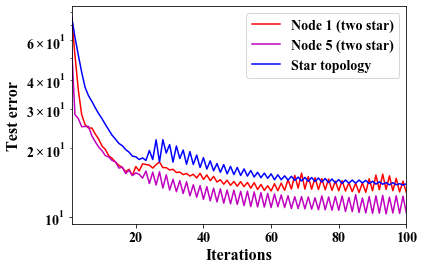

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Test error", fontsize=16)

errs1 = pd.read_csv("errTest_100_twoStar_Node1.csv", delimiter=",", header=None).values
errs5 = pd.read_csv("errTest_100_twoStar_Node5.csv", delimiter=",", header=None).values

plt.semilogy(list(range(1,Iterations+1)),errs1,'-r',label = 'Node 1 (two star)')
plt.semilogy(list(range(1,Iterations+1)),errs5,'-m',label = 'Node 5 (two star)')

errs_startTopology = pd.read_csv("err_test_100_star.csv", delimiter=",", header=None).values
plt.semilogy(list(range(1,Iterations+1)),errs_startTopology,'-b',label = 'Star topology')
legend()

# Observation
As expected the test error at Node 1 is higher compared with that of at Node 5. Interestingly, in contast to our expectation, the test error at Node 5 is even lower than that of the test error we obtained in star topology at the central server.

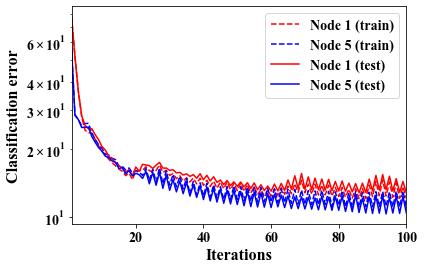

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline

Iterations = 100

plt.rcParams["font.family"] = 'Times New Roman'
matplotlib.rcParams.update({'font.size': 14})
axes = plt.gca()
axes.set_xlim([1,Iterations])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Classification error", fontsize=16)

errs1 = pd.read_csv("errTrain_100_twoStar_Node1.csv", delimiter=",", header=None).values
errs5 = pd.read_csv("errTrain_100_twoStar_Node5.csv", delimiter=",", header=None).values

plt.semilogy(list(range(1,Iterations+1)),errs1,'--r',label = 'Node 1 (train)')
plt.semilogy(list(range(1,Iterations+1)),errs5,'--b',label = 'Node 5 (train)')

errs1 = pd.read_csv("errTest_100_twoStar_Node1.csv", delimiter=",", header=None).values
errs5 = pd.read_csv("errTest_100_twoStar_Node5.csv", delimiter=",", header=None).values

plt.semilogy(list(range(1,Iterations+1)),errs1,'-r',label = 'Node 1 (test)')
plt.semilogy(list(range(1,Iterations+1)),errs5,'-b',label = 'Node 5 (test)')

legend()

# ADMM for OvR multiclass SVM

In this part we implement the ADMM algorithm with 10 workers for the MNIST dataset where it has 10 classes. Let us assume we are using $n$ samples to train, then $\mathbf{X}$ is $n\times 784$. For each worker $i$ we have the weight marix $\mathbf{w}^{(i)}=[\mathbf{w}^{(i)}_1,\dots,\mathbf{w}^{(i)}_{10}]$ such that the weight vector $\mathbf{w}^{(i)}_c$ corresponds to the worker $i$ and class $c$ and is $784\times 1$.

$\mathbf{y}$ is a matrix of $n\times 10$ such that if for the input sample with index $s$ the true class was $1$, then the row $y_s$ is $[0,1,0\dots,0]$.
As defined earlier the corresponding $t_s$ in this example is $t_s=[-1,1,-1\dots,-1]$.

In the OvR, for the worker $i$ and class $c$ and the corresponding column $\mathbf{t}_c$ we have:
$$f_c(\mathbf{w}^{(i)}):=f(\mathbf{x},\mathbf{t}_{c},\mathbf{w}^{(i)})=\frac{1}{n}\sum_{s=1}^{n}  \max\left(0,1- x_s \mathbf{w}^{(i)} \mathbf{t}_{s,c}\right)$$

So for each class $c$ we want to solve the following:
$$minimize \sum_{i=1}^N f_c(\mathbf{w}^{(i)})\qquad s.t. \qquad \mathbf{w}^{(i)}=\mathbf{z}_{ij}\quad for\quad i=1,...,N \quad, j\in\mathcal{N}_i  \qquad\&\qquad \mathbf{z}_{ij}=\mathbf{z}_{ji}$$


The Lagrangian loss function can be written as:
\begin{align}
    L=\sum_{i=1}^N f_c(\mathbf{w}^{(i)}) + \sum_{i=1}^N \sum_{j\in\mathcal{N}_i} \mathbf{u}_{ij}^T (\mathbf{w}^{(i)} - \mathbf{z}_{ij}) + \lambda/2 \sum_{i=1}^N \sum_{j\in\mathcal{N}_i} \lvert\lvert \mathbf{w}^{(i)} - \mathbf{z}_{ij}\rvert\rvert^2
\end{align}

So the ADMM steps for the class $c$ and worker $i$ are:

\begin{align}
\mathbf{w}^{(i),k+1}_c &= \arg\min\limits_{\mathbf{w}} \left(  f_c(\mathbf{w}) + \sum_{j\in\mathcal{N}_i} \mathbf{u}_{ij,c}^{k T} (w - z_{ij,c}^k) + \lambda/2 \sum_{j\in\mathcal{N}_i} \lvert\lvert \mathbf{w} - \mathbf{z}_{ij,c}^k\rvert\rvert^2\right)\\
\mathbf{z}_{ij,c}^{k+1}&=\frac{1}{2} \left(\mathbf{w}^{(i),k+1}_c + \mathbf{w}^{(j),k+1}_c + \frac{1}{\lambda} (\mathbf{u}_{ij,c}^k + \mathbf{u}_{ji,c}^k)\right)\\
\mathbf{u}_{ij,c}^{k+1}&= \mathbf{u}_{ij,c}^{k} + \lambda (\mathbf{w}^{(i),k+1}_c- \mathbf{z}_{ij,c}^{k+1})
\end{align}


## Implementation
We have used two approaches to solve the first step of the ADMM. One is using **cvxpy** to find the $\mathbf{w}$s. The second approach is using **GD** or **SGD**. 

The first approach is straightforward. However, it takes a lot of time for convergence.

For the second approach let $$M_c^{(i)}=f_c(\mathbf{w}) + \sum_{j\in\mathcal{N}_i} \mathbf{u}_{ij,c}^{k T} (\mathbf{w} - z_{ij,c}^k) + \lambda/2 \sum_{j\in\mathcal{N}_i} \lvert\lvert \mathbf{w} - \mathbf{z}_{ij,c}^k\rvert\rvert^2.$$
By taking the derivative we have:
$$\nabla M_c^{(i)}= \nabla f_c(\mathbf{w}_i) + \sum_{j\in\mathcal{N}_i} \mathbf{u}_{ij,c}^{k} + \lambda \sum_{j\in\mathcal{N}_i} \mathbf{w} - \mathbf{z}_{ij,c}^k$$
So the update rule of the ADMM can be substituted with:
\begin{align}
w_c^{(i),k+1}(0)&=\mathbf{0}\\
w_c^{(i),k+1}(t+1) &= w_c^{(i),k+1}(t) - \beta\, \nabla M^{(i)} 
\end{align}

In [5]:
def ADMM_Worker_OvR(X_data, t_data,w_k_i, CLASS_NUM, u_k, z_k, i_, lambda_, A_m, solver='GD',iters=30,beta=0.01):
    #print('in worker')
    # One vs rest multiple classification
    # solver is eithe GD or cvxpy
    # run the optimization for i-th block
    # X_data and y_data are local data in the i-th block
    # X_data is n x p
    # t_data is n x C with elements +1 or -1 
    # C is CLASS_NUM
    
    # w_k_i is the wieght matrix at k-th ADMM iteration and for i-th worker
    
    x=X_data
    t=t_data
    
    w_out=[]
    
    if solver=='GD':
        w_temp=np.concatenate(w_k_i,axis=1)
        cost_c0=[]
        for iter_ in range(iters):
            #Compute the gradient
            g1=Multi_SVM_cost_grad(x, t, w_temp)
            g2=np.zeros(w_temp.shape)
            g3=np.zeros(w_temp.shape)
            neigh=np.where(A_m[i_]==1)[0]
            for c in range(CLASS_NUM):
                for j in neigh:
                    g2[:,c]+=u_k[c][i_][j][:,0]
                    g3[:,c]+=w_temp[:,c]-z_k[c][i_][j][:,0]
            g=g1+g2+lambda_*g3
            w_temp=w_temp-beta*g
            print('gradNorm=',np.linalg.norm(g,'fro'))
            cost_c0.append(Multi_SVM_cost(x, t, w_temp)[0])
            #print('cost=',cost_c0[-1])
            #clfy=bin_SVM_classify(x_test.T, w)
            #Test_Y=np.where(y_test)[1].reshape(y_test.shape[0],1)
            #print('accuracy=', 100*len(np.where(clfy==Test_Y)[0])/Test_Y.shape[0])
            
        for c in range(CLASS_NUM):
            w_out.append(w_temp[:,c].reshape(w_temp.shape[0],1))
        return w_out,cost_c0
    
    if solver=='SGD':
        w_temp=np.concatenate(w_k_i,axis=1)
        cost_c0=[]
        for iter_ in range(iters):
            #Compute the gradient
            x_mini,t_mini=mini_batch(x,t,batch_size=100)
            g1=Multi_SVM_cost_grad(x_mini, t_mini, w_temp)
            g2=np.zeros(w_temp.shape)
            g3=np.zeros(w_temp.shape)
            neigh=np.where(A_m[i_]==1)[0]
            for c in range(CLASS_NUM):
                for j in neigh:
                    g2[:,c]+=u_k[c][i_][j][:,0]
                    g3[:,c]+=w_temp[:,c]-z_k[c][i_][j][:,0]
            g=g1+g2+lambda_*g3
            w_temp=w_temp-beta*g
            #print('\t gradNorm=',np.linalg.norm(g,'fro'))
            cost_c0.append(Multi_SVM_cost(x, t, w_temp)[0])
            #print('cost=',cost_c0[-1])
            
            ## test accuracy
            #clfy=bin_SVM_classify(x_test.T, w)
            #Test_Y=np.where(y_test)[1].reshape(y_test.shape[0],1)
            #print('accuracy=', 100*len(np.where(clfy==Test_Y)[0])/Test_Y.shape[0])
            
            ## train accuracy
            #clfy=bin_SVM_classify(x.T, w)
            #clfy_true=np.where(t>0)[1].reshape(x.shape[0],1)            
            #print('\t accuracy=', 100*len(np.where(clfy_true==clfy)[0])/x.shape[0])
        #print('\t \t cost=',Multi_SVM_cost(x, t, w_temp)[0])
        for c in range(CLASS_NUM):
            w_out.append(w_temp[:,c].reshape(w_temp.shape[0],1))
        return w_out,cost_c0  
    
    elif solver=='cvxpy':
        w_=[]
        loss_1=[]
        loss_2=[]
        loss_3=[]
        for c in range(CLASS_NUM):
            #print('   class: ',c)
            start_t=time.time()
            w_.append(cp.Variable((x.shape[1],1)) )      
            loss_1.append(cp.sum(cp.pos(1 - cp.multiply(t[:,c].reshape(t.shape[0],1), x @ w_[c] ))))

            loss_2.append(0) # second term in L
            loss_3.append(0) # third term in L

            neigh=np.where(A_m[i_]==1)[0]
            for j in neigh:
                loss_2[-1]+=(u_k[c][i_][j]).T@(w_[c]-z_k[c][i_][j])
                loss_3[-1]+=cp.norm(w_[c]-z_k[c][i_][j],2)**2                          

            #print('   solve for class ',c)
            prob = cp.Problem(cp.Minimize(loss_1[c]/x.shape[0] + loss_2[c] + 0.5*lambda_*loss_3[c]))
            prob.solve()
            #print('   solved')
            #print('i=',i_,'  argmin=',w_.value)
            w_out.append(w_[c].value)
            #print('   Duration: ',time.time()-start_t,' s\n')
        return w_out        
        

def ADMM_OvR(data_X_list, data_t_list,w_k , z_k, u_k, lambda_, A_m, WORKER_NUM,CLASS_NUM, solver='GD',iters=30,beta=0.01):
    #One vs rest multiple classification
    #ADMM with Binary SVM cost
    
    # The x_list and t_list are of dimension WORKER_NUM
    # The number of classes is CLASS_NUM

    # X_data is n x p
    # t_data is n x C with elements +1 or -1 
    # C is CLASS_NUM
    
    # u_k is the list u_ij and the lenth of each row is the number of nodes adjacent to worker i
    # for example [[u_11,u_13],[u_22,u_23],[u_33,u_31,u_32]]
    # z_k is the list z_ij and the lenth of each row is the number of nodes adjacent to worker i

    # A_m is the adjacency matrix
    # NUM_ITER is the number of iterations
    
    #WORKER_NUM is the number of workers  
    
    
    # w update
    w_new_s=[]
    cost_c0=[]
    
    for i in range(WORKER_NUM):
        print('\t worker=',i)
        start_t=time.time()
        if solver=='cvxpy':
            w_new_s.append(ADMM_Worker_OvR(data_X_list[i], 
                                           data_t_list[i],
                                           w_k_i=w_k[i],
                                           CLASS_NUM=CLASS_NUM,
                                           u_k=u_k,
                                           z_k=z_k,
                                           i_=i,
                                           lambda_=lambda_,
                                           A_m=A_m,
                                           solver='cvxpy'))
        elif solver=='GD':
            wi,ci0=ADMM_Worker_OvR(data_X_list[i],
                                       data_t_list[i],
                                       w_k_i=w_k[i],    
                                       CLASS_NUM=CLASS_NUM,
                                       u_k=u_k,
                                       z_k=z_k,
                                       i_=i,
                                       lambda_=lambda_,
                                       A_m=A_m,
                                       solver='GD',iters=iters,beta=beta)
            w_new_s.append(wi)
            cost_c0.append(np.asarray(ci0))
        elif solver=='SGD':
            wi,ci0=ADMM_Worker_OvR(data_X_list[i],
                                       data_t_list[i],
                                       w_k_i=w_k[i],    
                                       CLASS_NUM=CLASS_NUM,
                                       u_k=u_k,
                                       z_k=z_k,
                                       i_=i,
                                       lambda_=lambda_,
                                       A_m=A_m,
                                       solver='SGD',iters=iters,beta=beta)
            w_new_s.append(wi)
            cost_c0.append(np.asarray(ci0))
            
        print('\t Duration: ',time.time()-start_t,' s')
    w_k=w_new_s
    
    # z update
    z_new=[]
    for c in range(CLASS_NUM):
        z_new.append(np.zeros((WORKER_NUM,WORKER_NUM,data_X_list[0].shape[1],1)))
        for i in range(WORKER_NUM):
            neigh=np.where(A_m[i]==1)[0]
            for j in neigh:
                z_new[c][i][j]= 0.5*(w_k[i][c] + w_k[j][c] + (1/lambda_)*(u_k[c][i][j]+u_k[c][j][i]))
    
    # u update
    u_new=[]
    for c in range(CLASS_NUM):
        u_new.append(np.zeros((WORKER_NUM,WORKER_NUM,data_X_list[0].shape[1],1)))
        for i in range(WORKER_NUM):
            neigh=np.where(A_m[i]==1)[0]
            for j in neigh:
                u_new[c][i][j]=u_k[c][i][j] + lambda_*(w_k[i][c]-z_new[c][i][j])
            
    return w_new_s,z_new,u_new, cost_c0  

def Multi_SVM_cost(x, t, w):
    # x is n x p
    # t is n x C with elements +1 or -1     
    # w is p x C vector
    # C is the number of classes
    # n=6000 p=784 C=10
    svm_cost = np.matmul(x, w)
    svm_cost= 1-np.multiply(svm_cost,t) 
    return np.sum(np.maximum(0,svm_cost),axis=0)/x.shape[0]
    
def Multi_SVM_cost_grad(x, t, w):
    # x is n x p
    # t is n x C with elements +1 or -1     
    # w is p x C vector
    # C is the number of classes
    
    CLASS_NUM=w.shape[1]
    svm_cost = np.matmul(x, w)
    svm_cost= 1-np.multiply(svm_cost,t)
    ind=np.zeros(svm_cost.shape)
    # find the locations where the gradient is non-zero
    ind[svm_cost > 0] = 1
    
    
    svm_cost_grad = np.zeros((x.shape[1], CLASS_NUM))
    for c in range(CLASS_NUM):
        t_c=t[:,c].reshape(t.shape[0],1)
        ind_c=ind[:,c].reshape(ind.shape[0],1)
        g_c = -np.multiply(np.multiply(x, t_c),ind_c)
        svm_cost_grad[:, c] = g_c.sum(axis = 0)/x.shape[0]
    
    return svm_cost_grad


#Split dataset to num_worker workers
def split_workers(X_data, y_data, num_worker):
    # Split into 10 subdatasets for 10 workers
    data_X_list=[]
    data_y_list=[]
    num_data = len(y_data)
    num_per_data = num_data // num_worker
    for i_th in range(num_worker):
        j = num_per_data * (i_th + 1)
        i = i_th*num_per_data
        x_data_worker = X_data[i:j]
        y_data_worker = y_data[i:j]
        data_X_list.append(x_data_worker)
        data_y_list.append(y_data_worker)
        
    return data_X_list, data_y_list

def mini_batch(x,t,batch_size=100):
    # x is n x p
    # t is n x C with elements +1 or -1
    n=x.shape[0]
    ind=np.random.randint(0,n, batch_size)
    x_out=x[ind,:]
    t_out=t[ind,:]
    return x_out,t_out
    

def y_convert(y):
    # y is n x C 
    # y is 1 for the correct class and 0 for the rest
    # C is the number of classes
    # The output is +1 -1
    t=2*(y-0.5)
    return t  


def bin_SVM_classify1(x, w):
    # x is 784 by n
    # w is matrix of 784 by CLASS_NUM
    c_NUM=w.shape[1]
    scores = np.matmul(x.T, w)
    class_votes = np.zeros(scores.shape)
    class_votes[scores > 0] += 1
    for i in range(c_NUM):
        class_votes[scores[:,i] <= 0,:] += 1
    class_votes[scores <= 0] -= 1
    return np.argmax(class_votes, axis = 1).reshape(x.shape[1], 1)

def bin_SVM_classify2(x, w):
    # x is 784 by n
    # w is matrix of 784 by CLASS_NUM
    scores = np.matmul(x.T, w)
    return np.argmax(scores, axis = 1).reshape(x.shape[1], 1)

In [ ]:
WORKERS_NUM=10
CLASS_NUM=10

# Split into 10 subdatasets for 10 workers
data_X_list, data_y_list = split_workers(x_train, y_train, num_worker=WORKERS_NUM)
NUM_ITER=30


A=np.zeros((WORKERS_NUM,WORKERS_NUM))
A[0:4,4]=1
A[4,0:4]=1

A[4,5]=1
A[5,4]=1

A[6:10,5]=1
A[5,6:10]=1




z=[]
u=[]
w=[]
t_data=[]

for i in range(WORKERS_NUM):    
    t_data.append(y_convert(data_y_list[i]))

#Initiate w
for i in range(WORKERS_NUM):    
    w_=[]
    for c in range(CLASS_NUM):         
        w_.append(np.random.rand(data_X_list[0].shape[1],1))
    w.append(w_)



#Initiate u and z
for c in range(CLASS_NUM):        
    z.append(np.zeros((WORKERS_NUM,WORKERS_NUM,data_X_list[0].shape[1],1)))
    u.append(np.zeros((WORKERS_NUM,WORKERS_NUM,data_X_list[0].shape[1],1)))
    

Classify=[]
solved_w=[]
Cost_C0=[]
Test_Y=np.where(y_test)[1].reshape(y_test.shape[0],1)


for it in range(10):
    w,z,u,cost_c0=ADMM_OvR(data_X_list,t_data,w_k=w,z_k=z,u_k=u,lambda_=0.01,A_m=A, WORKER_NUM=WORKERS_NUM,CLASS_NUM=CLASS_NUM,
                   solver='SGD',iters=20,beta=0.1)
    solved_w.append(w)
    #Out for worker 0 as an example
    Cost_C0.append(cost_c0[0])
    Classify.append(bin_SVM_classify(x_test.T, np.concatenate(w[0],axis=1)))
    print('Test Accuracy: ',100*len(np.where(Classify[-1]==Test_Y)[0])/Test_Y.shape[0])
    
    

### Classification
To obtain the test accuracy, we use two methods for classification. The first method is based on a voting while in the second method we compute $\mathbf{x}\mathbf{w}_c$ for each class and take the maximum value indicaing the class.

## Performance

Here we plot the results of the loss and test accuracy for each worker and for 10 iterations of ADMM. In each iteration of ADMM, **18** communications are performed in the topology of (0,1,2,3)-4-5-(6,7,8,9).

### ADMM using cvxpy
The best result is **86%** accuracy using ADMM and classifying with the second method mentioned earlier.
The disadvantage of this method is the time required for running **cvxpy**.


In [ ]:
import pickle as pk
file=open('ADMM','rb')
(ADMM_w)=pk.load(file)
file.close()

out1=[]
out2=[]
acc1=[]
acc2=[]


for i in range(len(ADMM_w)):
    out1_=[]
    out2_=[]
    acc1_=[]
    acc2_=[]    
    for j in range(10):
        wj=ADMM_w[i][j] #Worker j            
        out1_.append(bin_SVM_classify1(x_test, np.concatenate(wj,axis=1)))
        out2_.append(bin_SVM_classify2(x_test, np.concatenate(wj,axis=1)))
        acc1_.append(100*len(np.where(out1_[-1].T==y_test)[1])/y_test.shape[0])
        acc2_.append(100*len(np.where(out2_[-1].T==y_test)[1])/y_test.shape[0])
    out1.append(out1_)
    out2.append(out2_)
    acc1.append(acc1_)
    acc2.append(acc2_)
    


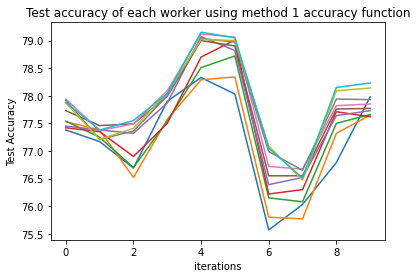

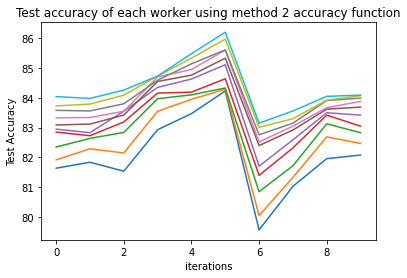

In [42]:
for i in range(10):
    plt.plot(acc1[:][i]) 
plt.title('Test accuracy of each worker using method 1 accuracy function')
plt.xlabel('iterations')
plt.ylabel('Test Accuracy')
plt.show()

    
for i in range(10):    
    plt.plot(acc2[:][i]) 
plt.title('Test accuracy of each worker using method 2 accuracy function')
plt.xlabel('iterations')
plt.ylabel('Test Accuracy')

plt.show()
    

The results suggest that ADMM reaches to sufficiently good results event with first iterations. We did not put the loss plot, since we should first determine a multi-class loss function for SVM as we used OvR. Otherwise, we could plot the loss for classifyin one class(e.g. class 0) vs. the rest. However, it might not be as informative as the accuracy.

Text(0.5, 1.0, 'The loss function for binary SVM of class 0 vs the rest')

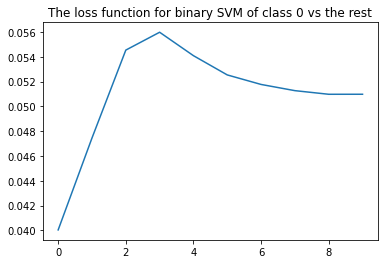

In [69]:
ADMM_loss=[]
for i in range(len(ADMM_w)):
    wz=ADMM_w[i][0] #iteration i    worker 0
    outz=x_test.T@np.concatenate(wz,axis=1)
    
    t_test=np.ones((y_test.shape[0],10))*-1
    outt=np.zeros(10)
    for k in range(y_test.shape[0]):
        t_test[k][y_test[k]]=1
        for j in range(10):
            outt[j]+=max(0,1-t_test[k][j]*outz[k][j])
    outt=outt/y_test.shape[0]
    
    ADMM_loss.append(outt[0])
plt.plot(ADMM_loss)
plt.title('The loss function for binary SVM of class 0 vs the rest')
    

### ADMM using SGD
In this approach, we have used minibatches of size **100** and chosen randomly. The SGD is performed for **20** iterations and learning rate of **0.01**.
In terms of accuracy, we can see that some workers can achieve **85%** accuracy while on average it is **75%**.


In [6]:
import pickle as pk
file=open('ADMM_SGD','rb')
(ADMM_w_SGD,ADMM_Cost_C0)=pk.load(file)
file.close()

out_SGD=[]
acc_SGD=[]


for i in range(len(ADMM_w_SGD)):
    out_=[]
    acc_=[]
    for j in range(10):
        wj=ADMM_w_SGD[i][j] #Worker j            
        out_.append(bin_SVM_classify1(x_test, np.concatenate(wj,axis=1)))
        acc_.append(100*len(np.where(out_[-1].T==y_test)[1])/y_test.shape[0])
    out_SGD.append(out_)
    acc_SGD.append(acc_)
    


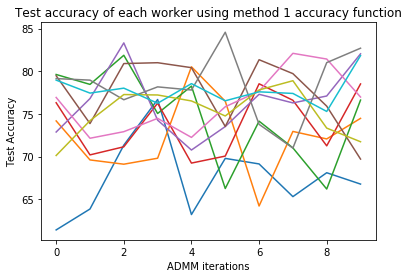

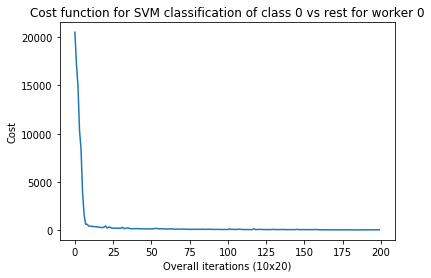

In [12]:
for i in range(10):
    plt.plot(acc_SGD[:][i]) 
plt.title('Test accuracy of each worker using method 1 accuracy function')
plt.xlabel('ADMM iterations')
plt.ylabel('Test Accuracy')
plt.show()

plt.plot(np.concatenate(ADMM_Cost_C0,axis=0))
plt.title('Cost function for SVM classification of class 0 vs rest for worker 0')
plt.xlabel('Overall iterations (10x20)')
plt.ylabel('Cost')

plt.show()